# Importing Packages

In [257]:
import os

import pandas as pd
import numpy as np

import keras
from keras.layers import Dense, Flatten, Conv2D

from keras.models import Sequential

from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

### Reading the Data

In [42]:
train =pd.read_csv('train.csv') 
test  = pd.read_csv('test.csv')

In [26]:
train.groupby('Class')['ID'].count()

Class
MIDDLE    10804
OLD        2396
YOUNG      6706
Name: ID, dtype: int64

In [90]:
train_data = train

In [91]:
train_data.groupby('Class')['ID'].count()

Class
MIDDLE    10804
OLD        2396
YOUNG      6706
Name: ID, dtype: int64

# Image Preprocessing

#### Splitting the Data into train and test

In [93]:
train_df, test_df = train_test_split(train_data,train_size=0.7,shuffle=True,random_state=1)

In [95]:
train_df.groupby('Class')['ID'].count()

Class
MIDDLE    7545
OLD       1701
YOUNG     4688
Name: ID, dtype: int64

In [96]:
test_df.groupby('Class')['ID'].count()

Class
MIDDLE    3259
OLD        695
YOUNG     2018
Name: ID, dtype: int64

### Creating Image Generator for Data Flow from Data Frame

In [97]:
train_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.25

)

In [98]:
test_generator = ImageDataGenerator(
    rescale=1./255
)

In [99]:
train_images = train_generator.flow_from_dataframe(
dataframe=train_df,
directory="./Train/",
x_col="ID",
y_col="Class",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(32,32)
)

Found 10451 validated image filenames belonging to 3 classes.


In [100]:
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    directory="./Train/",
    x_col="ID",
    y_col="Class",
    target_size=(32,32),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 3483 validated image filenames belonging to 3 classes.


In [101]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    directory="./Train/",
    x_col="ID",
    y_col="Class",
    target_size=(32, 32),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
    
)

Found 5972 validated image filenames belonging to 3 classes.


# Actual image with Labels

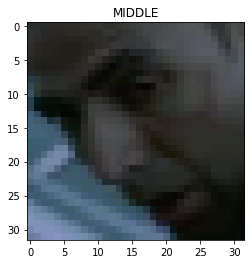

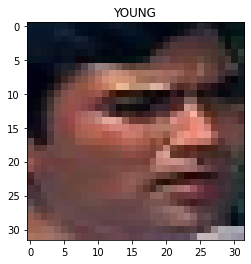

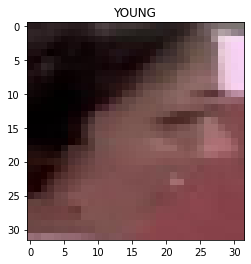

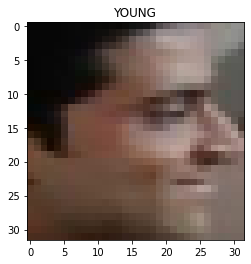

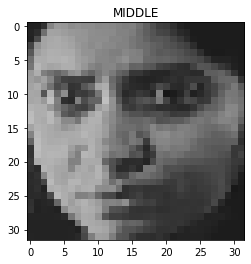

In [232]:
for batch in test_images:
    image = batch[0]
    label = batch[1]
    for i in range(5):
        plt.imshow(image[i])
        plt.title(list(test_images.class_indices.keys())[np.argmax(label[i])])
        plt.show()
        
    break

## Model Building 

In [102]:
from keras.layers import Input, MaxPool2D, GlobalAveragePooling2D
from keras.models import Model

In [164]:
inputs = Input(shape=(32, 32, 3))
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = MaxPool2D()(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = MaxPool2D()(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPool2D()(x)
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(3, activation='softmax')(x)


In [165]:
model1 = Model(inputs=inputs, outputs=outputs)

In [166]:
model1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [138]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [167]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)


In [168]:
history = model1.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[es, mc],
    
)

Epoch 1/100
327/327 [==============================] - ETA: 0s - loss: 0.9544 - accuracy: 0.5406
Epoch 1: val_accuracy improved from -inf to 0.53976, saving model to best_model.h5
327/327 [==============================] - 121s 364ms/step - loss: 0.9544 - accuracy: 0.5406 - val_loss: 0.9397 - val_accuracy: 0.5398
Epoch 2/100
327/327 [==============================] - ETA: 0s - loss: 0.8818 - accuracy: 0.5822
Epoch 2: val_accuracy improved from 0.53976 to 0.58570, saving model to best_model.h5
327/327 [==============================] - 32s 97ms/step - loss: 0.8818 - accuracy: 0.5822 - val_loss: 0.8757 - val_accuracy: 0.5857
Epoch 3/100
327/327 [==============================] - ETA: 0s - loss: 0.7884 - accuracy: 0.6504
Epoch 3: val_accuracy improved from 0.58570 to 0.66322, saving model to best_model.h5
327/327 [==============================] - 34s 103ms/step - loss: 0.7884 - accuracy: 0.6504 - val_loss: 0.7670 - val_accuracy: 0.6632
Epoch 4/100
327/327 [==============================]

### Peformance Validation

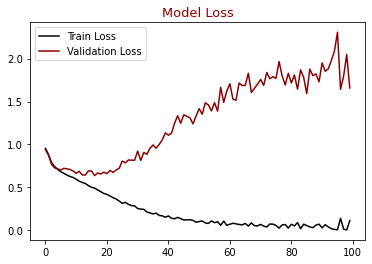

In [169]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(history.history["loss"],label = "Train Loss", color = "black")
plt.plot(history.history["val_loss"],label = "Validation Loss", color = "darkred")
plt.title("Model Loss", color = "darkred", size = 13)
plt.legend()
plt.show()


In [148]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [153]:
from keras.models import load_model 

In [154]:
model2 = load_model('best_model.h5')

## Model Evaluation

In [155]:
model2.evaluate(test_images)

187/187 [==============================] - 149s 793ms/step - loss: 0.7184 - accuracy: 0.7252


[0.7184053659439087, 0.7252177000045776]

In [156]:
model1.evaluate(test_images)

187/187 [==============================] - 14s 75ms/step - loss: 1.3677 - accuracy: 0.7078


[1.3676518201828003, 0.7078030705451965]

# Model Prediction

In [171]:
pred_age = model2.predict(test_images)

187/187 [==============================] - 106s 569ms/step


In [229]:
pred_age_ind = [np.argmax(i) for i in  pred_age[:5]]
pred_age_ind

[2, 2, 2, 2, 0]

In [230]:
test_images.labels[:5]

[2, 2, 0, 2, 0]

In [209]:
test_images.class_indices

{'MIDDLE': 0, 'OLD': 1, 'YOUNG': 2}

# Predicted Image with Labels

1/1 [==============================] - 0s 24ms/step


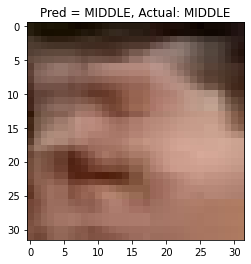

In [255]:
for batch in test_images:
    image = batch[0]
    label = [np.argmax(i) for i in batch[1]]
    #print(label)
    pred= model2.predict(image)
    pred_ind = [np.argmax(i) for i in pred]
    #print(pred_ind)
    for i in range(1):
        plt.imshow(image[i])
        plt.title( "Pred = {}, Actual: {}" .format( list(test_images.class_indices.keys())[pred_ind[i]], list(test_images.class_indices.keys())[label[i]]))
        plt.show()
    break